# **`word2vec` Training Workflow (Ngrams)**
In this workflow, we first train `word2vec` models across years using a range of hyperparameters (e.g., vector dimensions and training epochs). The purpose is twofold: (1) to determine whether models from earlier years are reasonably stable, and (2) choose a set of hyperparameters that yield good results across all years. Models are evaluated using "intrinsic" tests of similarity and analogy performance, which we visualize using plots and analyze using linear regression.

Once we've chosen our hyperparameters, we use them to train models for every year from 1900 through 2019.

## **Setup**
### Imports

In [2]:
%load_ext autoreload
%autoreload 2

from train.word2vec import (
    build_word2vec_models,
    evaluate_word2vec_models,
    plot_evaluation_results,
    run_regression_analysis,
    plot_regression_results,
    transfer_models
)
from train.word2vec.normalize_and_align_models import normalize_and_align_vectors

### Configure
Here we set basic parameters: the corpus path stub, corpus release, language, and ngram size.

In [3]:
db_path_stub = '/scratch/edk202/NLP_corpora/Google_Books/'
release = '20200217'
language = 'eng-us'
ngram_size = 5

## **Test Model Hyperparameters**
### Train Models
Here we test models from 1900 tp 2015 in 5-year increments, cycling through a range of reasonable hyperparameters. In this workflow, we constrain our grid search as follows:
1. We stick to the Skip-Gram (`skip-gram`) approach. Skip-gram is known to be more efficient than Continuous Bag of Words (`CBOW`) for Google n-gram data.
2. We test vector dimensions (`vector_size`) from 100 to 300. Our vocabulary is probably too small to support the extraction of more than 300 meaningful features.
3. We test training epochs (`epochs`) from 5 to 30. More than 30 epochs risks overfitting.
4. We set the minimum word count (`min_count`) to 1, meaning that no words will be excluded from training. Our whitelist ensures that all vocabulary words appear frequently in every corpus from 1900 to 2015.
5. Weighting (`weight_by`) is set to `doc_freq`. We feed the model specific 5-grams in proportion to their document frequency.
6. We set a context window (`window`) of 4. This width extracts as much context as possible from 5-grams.

In [4]:
build_word2vec_models(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    years=(1900, 2019),
    year_step=10,
    weight_by=('none',),
    vector_size=(100, 200, 300),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10, 20, 30),
    max_parallel_models=64,
    workers_per_model=16,
    mode="restart",
    unk_mode="retain",
    use_corpus_file=True,
    cache_corpus=True
);


WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2026-01-04 00:23:10

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             ...k202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/5grams_pivoted.db
Model directory:      ...atch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/models_test
Log directory:        ...k202/NLP_models/Google_Books/20200217/eng-us/5gram_files/logs_test/training
Parallel models:      64

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2019 (step=10, 12 years)
Weighting:            ('none',)
Vector size:          (100, 200, 300)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (10, 20, 30)

Data Options
──────────────

Training Models: 100%|██████████| 108/108 [3:35:12<00:00, 119.56s/ models] 


Training Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models trained:       108
Model directory:      ...atch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/models_test
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



In [13]:
evaluate_word2vec_models(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    save_mode='overwrite',
    run_similarity=True,
    run_analogy=True,
    workers=128
);


WORD2VEC MODEL EVALUATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2026-01-04 04:04:44

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      ...atch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/models_test
Evaluation file:      ...models/Google_Books/20200217/eng-us/5gram_files/evaluation_results_test.csv
Log directory:        ...02/NLP_models/Google_Books/20200217/eng-us/5gram_files/logs_test/evaluation
Save mode:            overwrite

Evaluation Datasets
────────────────────────────────────────────────────────────────────────────────────────────────────
Similarity dataset:   ...lexichron/lib/python3.11/site-packages/gensim/test/test_data/wordsim353.tsv
Analogy dataset:      ...hron/lib/python3.11/site-packages/gensim/test/test_data/questions-words.txt

Found 108 models to evaluate



Evaluating models: 100%|██████████| 108/108 [27:03<00:00, 15.03s/ models]   



Evaluation Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models evaluated:     108
Results saved to:     ...models/Google_Books/20200217/eng-us/5gram_files/evaluation_results_test.csv
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━



### Visualize Model Performance
The code below plots the results of the similarity and analogy tests for easy inspection.
#### Similarity Results

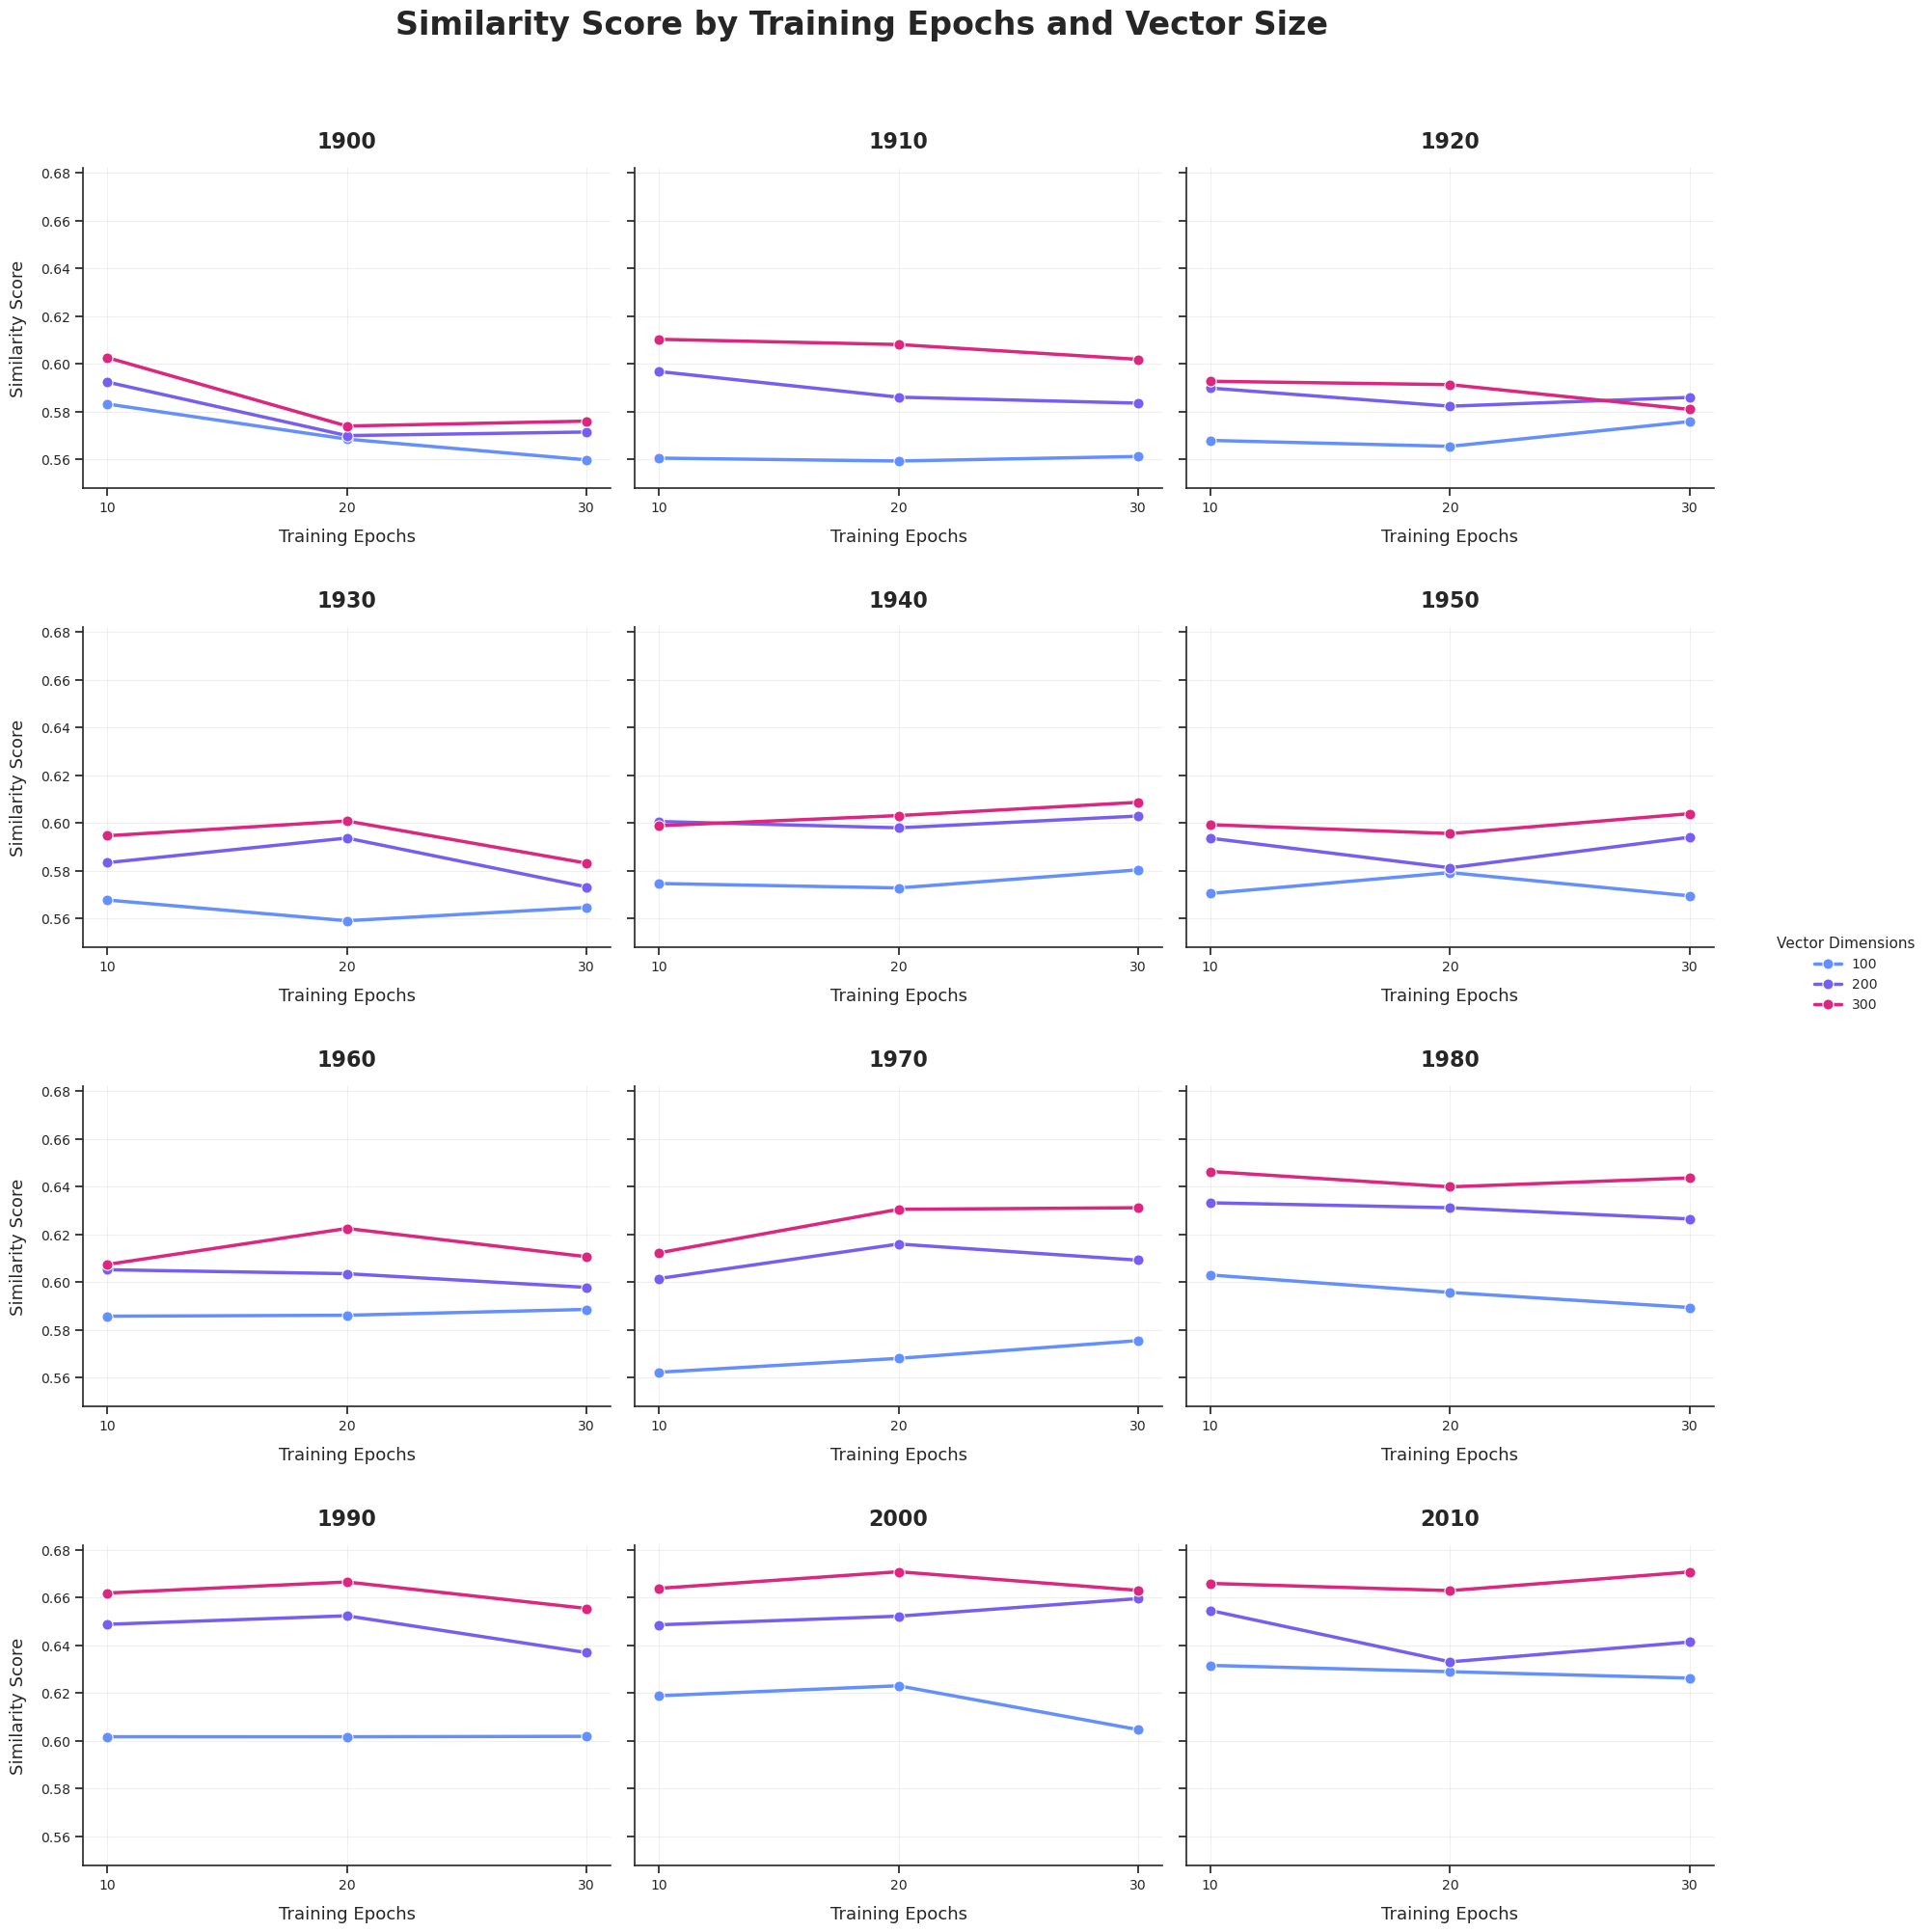

In [6]:
plot_evaluation_results(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='similarity_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Similarity Score by Training Epochs and Vector Size'
)

#### Analogy Results

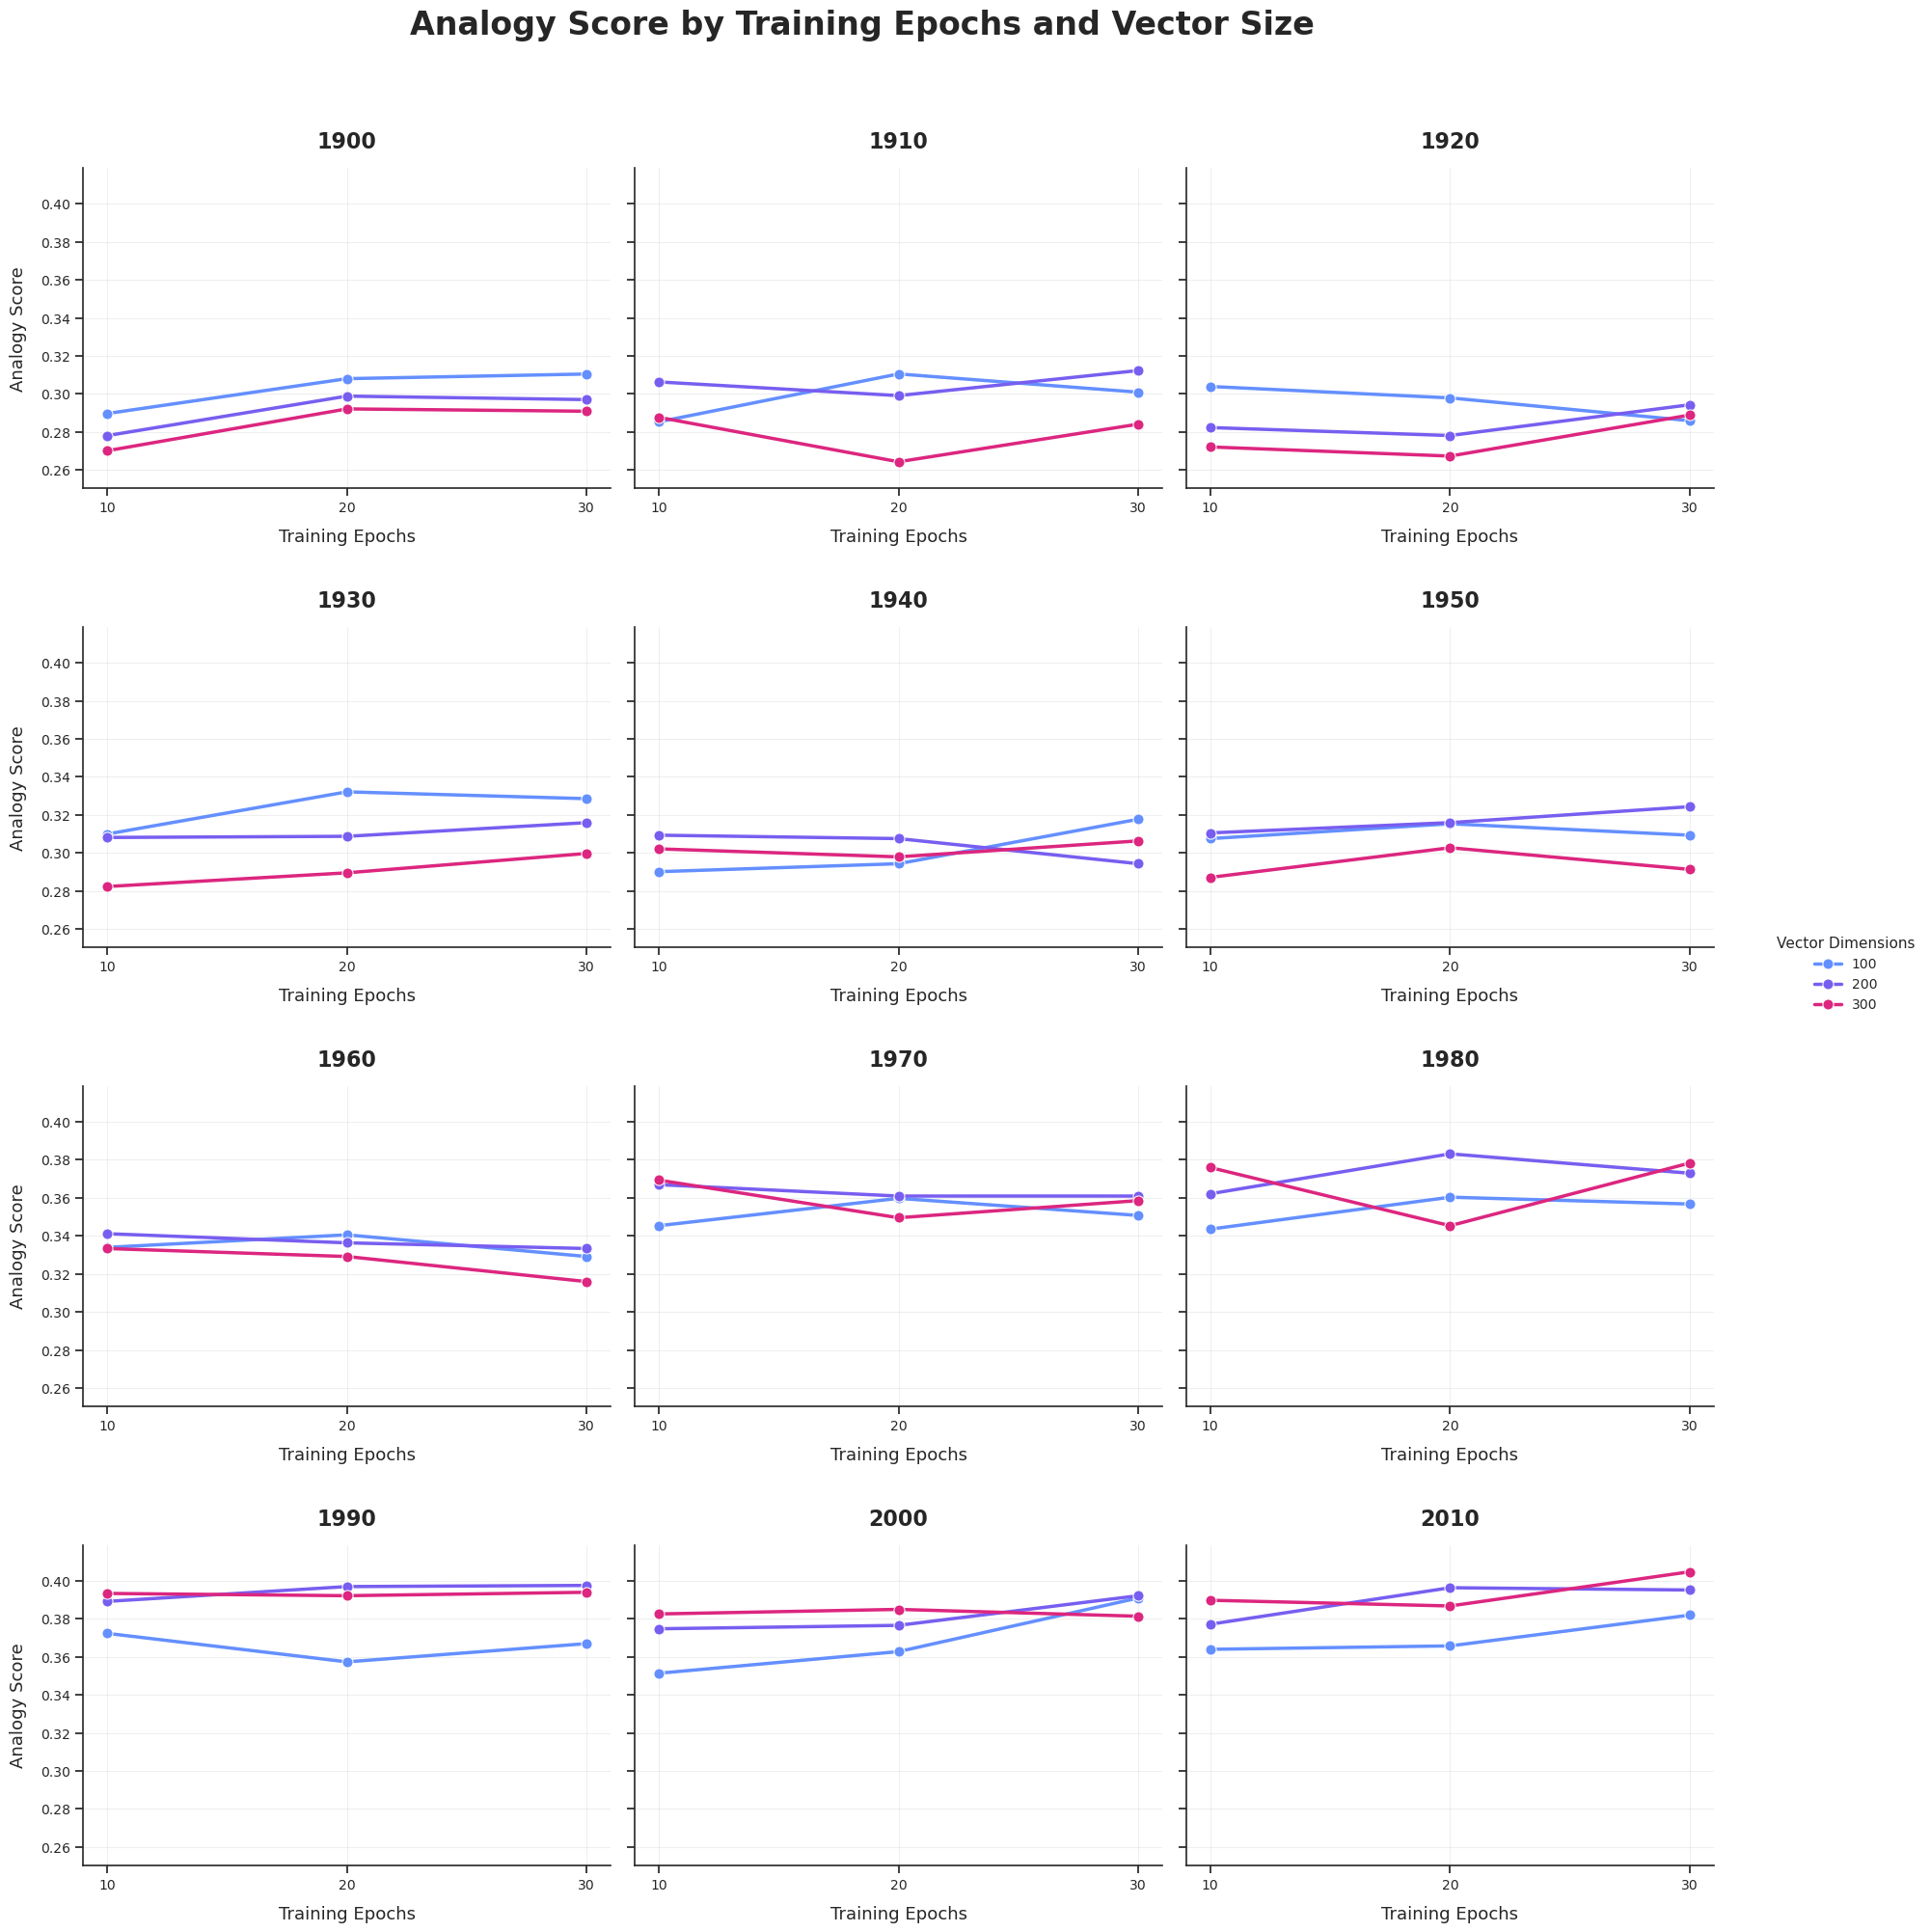

In [14]:
plot_evaluation_results(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    verbose=False,
    metric='analogy_score',
    x_vars=['epochs', 'vector_size'],
    panel_by='year',
    plot_type='line',
    plot_title='Analogy Score by Training Epochs and Vector Size'
)

### Regression Analysis
The code below runs regression analyses on the similarity and analogy results.
#### Predictors of Similarity Performance

Loading data from: /scratch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/evaluation_results_test.csv
Loaded 108 observations
Number of years: 12

Model specification:
  Formula: similarity_score ~ scale(year) + scale(vector_size) + scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Mixed-effects model failed (Singular matrix). Falling back to OLS regression...
Model converged successfully!

                            OLS Regression Results                            
Dep. Variable:       similarity_score   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     167.0
Date:                Sun, 04 Jan 2026   Prob (F-statistic):           1.27e-39
Time:                        04:03:51   Log-Likelihood:                 319.04
No. Observations:                 108   AIC:                            -630.1
Df Residuals:        

/scratch/edk202/.conda/envs/lexichron/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


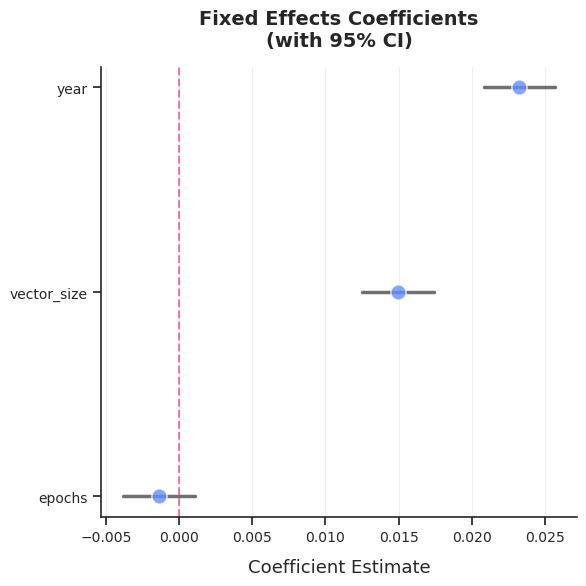

In [12]:
results = run_regression_analysis(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='similarity_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=None
)

plot_regression_results(results)

#### Predictors of Analogy Performance

Loading data from: /scratch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/evaluation_results_test.csv
Loaded 108 observations
Number of years: 12

Model specification:
  Formula: analogy_score ~ scale(year) + scale(vector_size) + scale(epochs)
  Random effects: year

Fitting mixed-effects model...
Mixed-effects model failed (Singular matrix). Falling back to OLS regression...
Model converged successfully!

                            OLS Regression Results                            
Dep. Variable:          analogy_score   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     165.0
Date:                Sun, 04 Jan 2026   Prob (F-statistic):           2.15e-39
Time:                        04:33:26   Log-Likelihood:                 291.98
No. Observations:                 108   AIC:                            -576.0
Df Residuals:           

/scratch/edk202/.conda/envs/lexichron/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


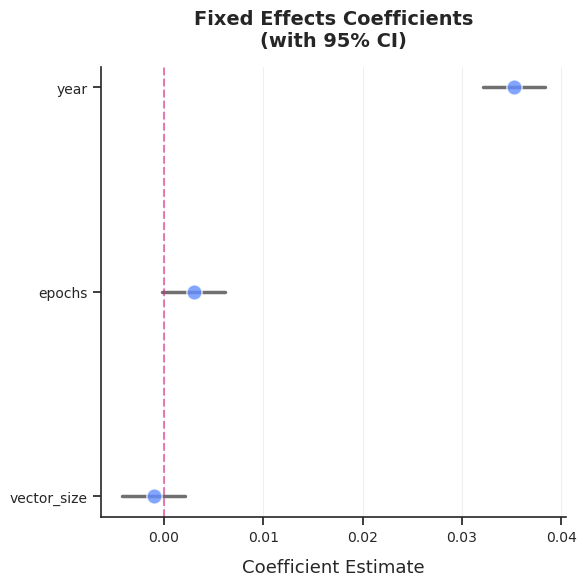

In [15]:
results = run_regression_analysis(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='test',
    model_type="auto",
    outcome='analogy_score',
    predictors=['year', 'vector_size', 'epochs'],
    interactions=None,
)

plot_regression_results(results)

## **Transfer or Train Final Models**

We have two options now that the hyperparameter search is complete. If the desired final models are in the search set, we can simply transfer them to a new directory for analysis. Or, if the desired models aren't in the test set, we can train the final models and place them in the analysis directory.

### Transfer Final Models

In [8]:
result = transfer_models(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    source_suffix='test',
    dest_suffix='final',
    filter_params={'vector_size': 300, 'epochs': 10},
    overwrite=True
)


Removing existing destination directory: /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final

MODEL TRANSFER
Source:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_test
Destination: /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final
Filters:     {'vector_size': 300, 'epochs': 10}
Validate:    True



Transferring models: 100%|██████████| 480/480 [00:11<00:00, 42.70 files/s]


TRANSFER COMPLETE
Models found:      120
Transferred:       120
Skipped:           0
Destination:       /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final



### Train Final Models


In [ ]:
build_word2vec_models(
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    db_path_stub=db_path_stub,
    dir_suffix='final',
    years=(1900, 2019),
    year_step=1,
    weight_by=('none',),
    vector_size=(300,),
    window=(4,),
    min_count=(1,),
    approach=('skip-gram',),
    epochs=(10,),
    max_parallel_models=16,
    workers_per_model=16,
    mode="restart",
    unk_mode="retain",
    use_corpus_file=True,
    temp_dir='/scratch/edk202/lexichron/temp_corpus'
);


WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2026-01-04 12:38:47

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             ...k202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/5grams_pivoted.db
Model directory:      ...tch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/models_final
Log directory:        ...202/NLP_models/Google_Books/20200217/eng-us/5gram_files/logs_final/training
Parallel models:      64

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2019 (120 years)
Weighting:            ('none',)
Vector size:          (300,)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (10,)

Data Options
──────────────────────────────────────


WORD2VEC MODEL TRAINING
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2026-01-04 12:38:47

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Database:             ...k202/NLP_corpora/Google_Books/20200217/eng-us/5gram_files/5grams_pivoted.db
Model directory:      ...tch/edk202/NLP_models/Google_Books/20200217/eng-us/5gram_files/models_final
Log directory:        ...202/NLP_models/Google_Books/20200217/eng-us/5gram_files/logs_final/training
Parallel models:      64

Training Parameters
────────────────────────────────────────────────────────────────────────────────────────────────────
Years:                1900–2019 (120 years)
Weighting:            ('none',)
Vector size:          (300,)
Context window:       (4,)
Minimum word count:   (1,)
Approach:             ('skip-gram',)
Training epochs:      (10,)

Data Options
──────────────────────────────────────

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/edk202/lexichron/temp_corpus/w2v_corpus_y1902_wbnone_9cbaoddz.txt'

## **Normalize and Align Models**

Before we can use the models for diachronic analysis, we need to unit-normalize the vectors and align them across years using Procrustes rotation. The `normalize_and_align_vectors` function does this.

In [3]:
normalize_and_align_vectors(
    db_path_stub=db_path_stub,
    ngram_size=ngram_size,
    repo_release_id=release,
    repo_corpus_id=language,
    weighted_alignment=True,
    stability_method='combined',
    include_frequency=True,
    frequency_weight=0.3,
    dir_suffix='final',
    anchor_year=1900,
    workers=128
)


WORD2VEC MODEL NORMALIZATION & ALIGNMENT
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
Start Time: 2025-12-30 12:35:35

Configuration
════════════════════════════════════════════════════════════════════════════════════════════════════
Model directory:      /scratch/edk202/NLP_models/Google_Books/20200217/eng/5gram_files/models_final
Output directory:     ...LP_models/Google_Books/20200217/eng/5gram_files/models_final/norm_and_align
Anchor year:          1900
Total models:         120
Parallel workers:     128

Alignment Method
────────────────────────────────────────────────────────────────────────────────────────────────────
Type:                 Weighted Procrustes
Stability metric:     combined
Include frequency:    Yes
Frequency weight:     0.30 (30% frequency, 70% stability)


Stability Weight Computation
════════════════════════════════════════════════════════════════════════════════════════════════════
Loading 120 models...

Loading models: 100%|██████████| 120/120 [00:09<00:00, 12.37it/s]


Computing shared vocabulary...
Excluded 1 special token(s) from shared vocabulary
Shared vocabulary size: 28257 words
Computing stability weights using combined + frequency (weight=0.30) for 28257 words across 120 models...
Computing combined stability metric...
Computing mean frequency scores...
Final weight range: 0.0734 (lowest) to 0.8878 (highest)

Top 10 highest-weighted words:
  upon                 0.8878
  necessity            0.8653
  considerable         0.8641
  definite             0.8604
  satisfactory         0.8558
  company              0.8526
  connection           0.8524
  will                 0.8502
  shall                0.8500
  inasmuch             0.8477

Processing Models
════════════════════════════════════════════════════════════════════════════════════════════════════


Aligning models: 100%|██████████| 119/119 [07:12<00:00,  3.63s/ models]



Alignment Complete
════════════════════════════════════════════════════════════════════════════════════════════════════
Models processed:     120
Output directory:     ...LP_models/Google_Books/20200217/eng/5gram_files/models_final/norm_and_align
Total runtime:        0:07:43.620977
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

